<a href="https://colab.research.google.com/github/orin00/colab/blob/main/240423_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.chdir('/content/drive/MyDrive/DCGAN')

In [2]:
!pwd

/content/drive/MyDrive/DCGAN


In [3]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Dense, Flatten, Reshape, BatchNormalization, Dropout, ReLU, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from PIL import Image
import pathlib
import warnings
import os
warnings.filterwarnings('ignore')

In [4]:
!pip install kaggle # 캐글 api를 코랩에 설치

In [5]:
# kaggle 폴더 내에 API tokken을 저장
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# API 를 통해서 데이터 전송
!kaggle datasets download -d splcher/animefacedataset

animefacedataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
!unzip animefacedataset.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: images/62764_2019.jpg   
  inflating: images/62765_2019.jpg   
  inflating: images/62766_2019.jpg   
  inflating: images/62767_2019.jpg   
  inflating: images/62768_2019.jpg   
  inflating: images/62769_2019.jpg   
  inflating: images/6276_2003.jpg    
  inflating: images/62770_2019.jpg   
  inflating: images/62771_2019.jpg   
  inflating: images/62772_2019.jpg   
  inflating: images/62773_2019.jpg   
  inflating: images/62774_2019.jpg   
  inflating: images/62775_2019.jpg   
  inflating: images/62776_2019.jpg   
  inflating: images/62777_2019.jpg   
  inflating: images/62778_2019.jpg   
  inflating: images/62779_2019.jpg   
  inflating: images/6277_2003.jpg    
  inflating: images/62780_2019.jpg   
  inflating: images/62781_2019.jpg   
  inflating: images/62782_2019.jpg   
  inflating: images/62783_2019.jpg   
  inflating: images/62784_2019.jpg   
  inflating: images/62785_2019.jpg   
  inflating: images/62786_2019.jpg   
  inflating: i

In [9]:
## 데이터셋 이미지 전처리
def getImage(path, image_size=(64,64)):
  images = []
  for img in os.listdir(path):
    temp_img = Image.open(path+'/'+img) # 이미지 한장씩 불러오기
    temp_img = temp_img.convert('RGB') # RGB로 변환
    image = temp_img.resize(image_size) # 혹시 사이즈가 다른 이미지가 있을까봐 resize함(64,64)
    image = np.asarray(image) # 해당 이미지를 어레이로 변환
    image = ((image - 127.5) / 127.5).astype('float32') # -1~1 사이 값으로 변환
    images.append(image)
  return np.array(images)

In [10]:
image_path='./images'
train_images = getImage(image_path)

In [11]:
print(train_images.shape)

(63565, 64, 64, 3)


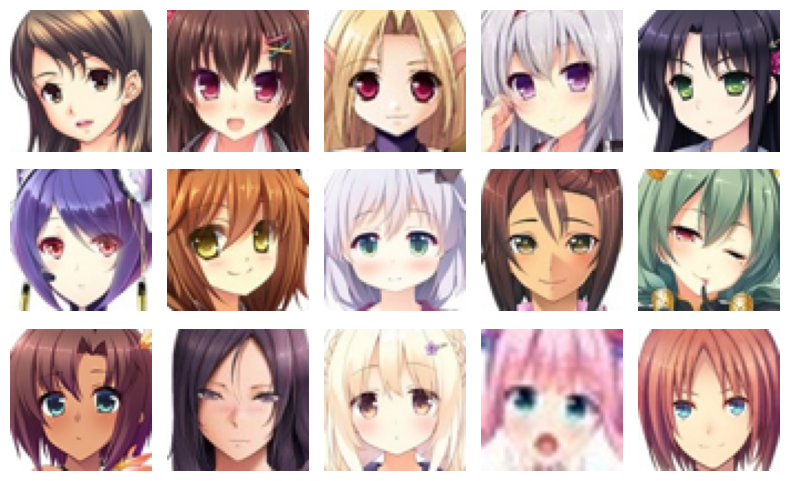

In [12]:
fig, axes = plt.subplots(3, 5)
fig.set_size_inches(8, 5)

for i in range(15):
  ax = axes[i // 5, i % 5]
  img = (train_images[i] * 127.5) + 127.5
  ax.imshow(img.astype(int))
  ax.imshow
  ax.axis('off')

plt.tight_layout()
plt.show()

In [13]:
## Generator 만들기
from tensorflow.keras.initializers import RandomNormal

## 초기값 설정 : 평균 = 0, 표준편차 = 0.02인 정규분포에 해당하는 데이터를 사용
kl = RandomNormal(mean=0.0, stddev=0.02)

## 입력 크기 : 입력은 1차원 벡터
input_dim = 300

## 생성자 만들기
def Generator_Model():

  model = Sequential()
  # 입력층
  model.add(Dense(8*8*512, input_dim=input_dim))
  model.add(ReLU()) # 활성화 함수
  model.add(Reshape((8,8,512))) # 1 차원 => 3 차원 데이터로 변환
  # CNN
  model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same', kernel_initializer=kl))
  model.add(ReLU())
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=kl))
  model.add(ReLU())
  model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=kl))
  # 출력층
  model.add(Conv2D(3, (4,4), padding='same', activation='sigmoid'))

  return model

generator = Generator_Model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             9863168   
                                                                 
 re_lu (ReLU)                (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 256)       2097408   
 anspose)                                                        
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 128)       524416    
 Transpose)                                             

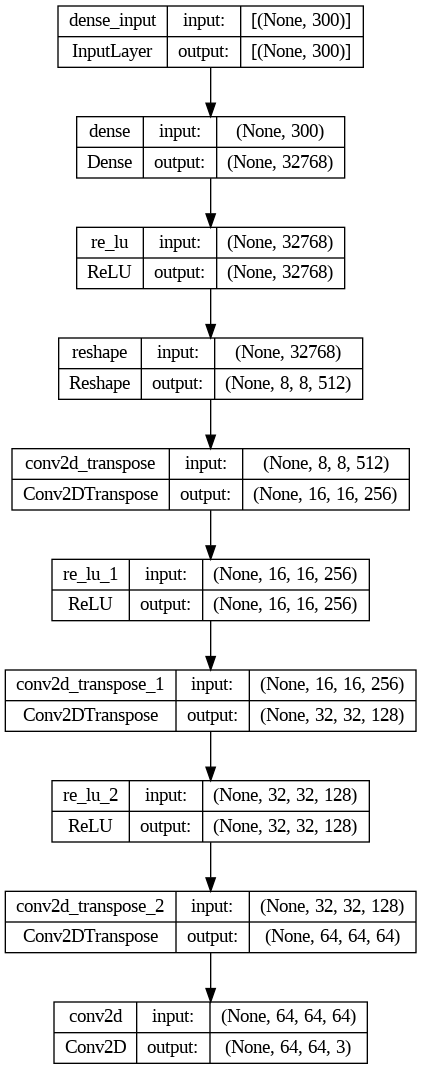

In [14]:
import tensorflow.keras.utils as utils

utils.plot_model(generator, show_shapes=True, to_file='generator_model.png')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 62, 62, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 29, 29, 128)       0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 128)       0         
 g2D)                                                 

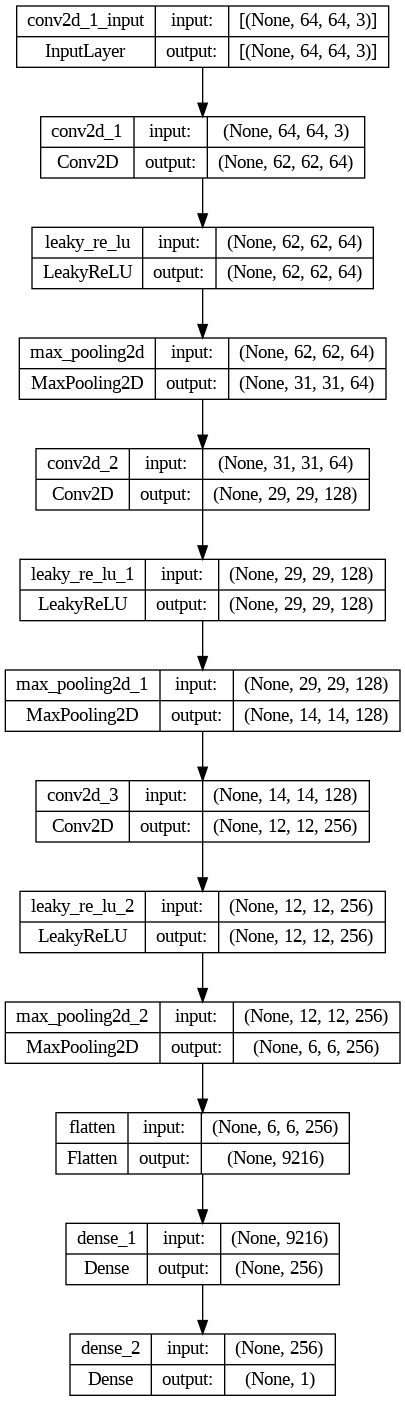

In [15]:
# Discriminator 만들기
def Discriminator_Model():
  input_shape = (64,64,3)
  model = Sequential()
  ## CNN 이진 분류 모델
  model.add(Conv2D(64, (3,3), input_shape = input_shape))
  model.add(LeakyReLU())
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(128, (3,3), input_shape = input_shape))
  model.add(LeakyReLU())
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(256, (3,3), input_shape = input_shape))
  model.add(LeakyReLU())
  model.add(MaxPooling2D(pool_size=(2,2)))

  # 출력층
  model.add(Flatten())
  model.add(Dense(256, activation='LeakyReLU'))
  model.add(Dense(1, activation='sigmoid'))

  return model


discriminator = Discriminator_Model()
discriminator.summary()

utils.plot_model(discriminator, show_shapes=True, to_file='discriminator_model.png')

In [16]:
class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim=input_dim):
        super().__init__()
        self.generator = generator  # 생성자 네트워크
        self.discriminator = discriminator  # 감별자 네트워크
        self.latent_dim = latent_dim  # 입력 노이즈 차원
        # 손실 함수 계산을 위한 지표
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')

    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer  # 생성자의 옵티마이저
        self.d_optimizer = d_optimizer  # 감별자의 옵티마이저
        self.loss_fn = loss_fn  # 손실 함수

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 감별자 훈련
        with tf.GradientTape() as tape:
            pred_real = self.discriminator(real_images, training=True)
            real_labels = tf.ones((batch_size, 1))
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)

            fake_images = self.generator(random_noise)
            pred_fake = self.discriminator(fake_images, training=True)
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            d_loss = (d_loss_real + d_loss_fake) / 2

        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        # 생성자 훈련
        labels = tf.ones((batch_size, 1))
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(labels, pred_fake)

        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}


In [17]:
class DCGANMonitor(keras.callbacks.Callback):
  def __init__(self, num_imgs=25, latent_dim=input_dim):
    self.num_imgs = num_imgs # 생성할 이미지 수
    self.latent_dim = latent_dim # 노이즈 차원
    self.noise = tf.random.normal([self.num_imgs, self.latent_dim]) # 이미지 생성을 위한 노이즈

  def on_epoch_end(self, epoch, logs=None):
    g_img = self.model.generator(self.noise) # 생성된 이미지
    g_img = (g_img * 127.5) + 127.5 # 이미지 정규화 해제
    g_img.numpy() # 넘파이 배열로 변환

  def on_train_end(self, logs=None):
    self.model.generator.save(DCGAN.h5) # 모델 저장

In [18]:
## 진짜 마지막 훈련
epochs = 30 # 훈련 횟수
lr_g = 0.0003 # 생성자의 학습률
lr_d = 0.0001 # 감별자의 학습률
beta = 0.5 # Adam 최적화의 베타1 파라미터
latent_dim = 300 # 입력값의 dim

dcgan = DCGAN(generator, discriminator, latent_dim = input_dim)

dcgan.compile(
    g_optimizer = Adam(lr_g, beta_1 = beta),
    d_optimizer = Adam(lr_d, beta_1 = beta),
    loss_fn = BinaryCrossentropy()
)

In [ ]:
# 이 시점에서 GPU로 변경 후
history = dcgan.fit(train_images, epochs=epochs,
                    callbacks=[DCGANMonitor()])